# Addressing sensetivity to outliers

### **Definition**

Sensitivity to outliers refers to the extent to which a model's predictions are influenced by extreme or atypical data points. A model that is highly sensitive to outliers may exhibit significant changes in its output even when a single value lies far outside the typical range of the data.

### **Description**

Volatility models, especially those based on squared returns (like GARCH), are highly sensitive to extreme values. Outliers can distort model estimates, leading to overestimated or spurious volatility spikes that do not reflect the actual market risk. This phenomenon has been explored in detail in financial econometrics literature [Bollerslev, 1986; Tsay, 2010; Cont, 2001].

### **Demonstration**

We compare how different volatility models respond to outliers:

* Standard GARCH(1,1) with Gaussian residuals
* GARCH(1,1) with Student’s t-distribution
* Rolling standard deviation (non-parametric baseline)

For these purposes, we use synthetic data into which we have manually introduced several outliers.

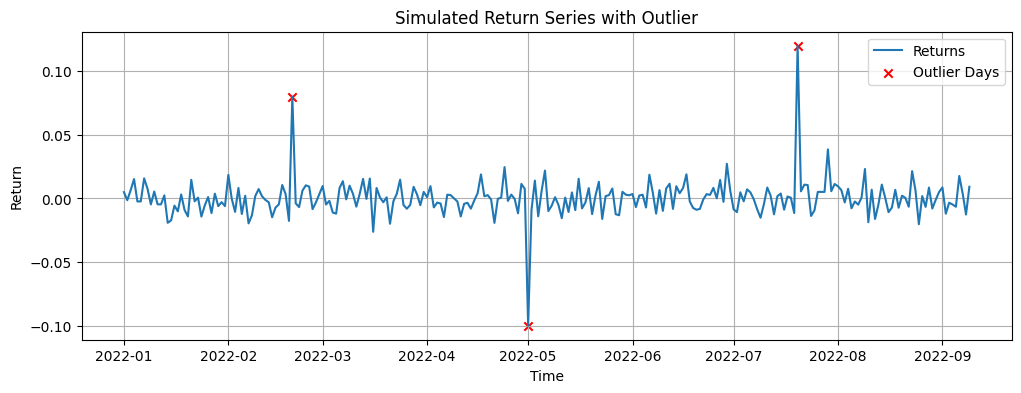

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import zscore

# Simulate returns with outliers
np.random.seed(42)
dates = pd.date_range(start='2022-01-01', periods=252)
returns = np.random.normal(0, 0.01, len(dates))
returns[[50, 120, 200]] = [0.08, -0.1, 0.12]

data = pd.DataFrame({'Return': returns}, index=dates)

# Outlier detection
data['Z-Score'] = zscore(data['Return'])
data['Outlier'] = np.abs(data['Z-Score']) > 3

plt.figure(figsize=(12, 4))
plt.plot(data.Return, label='Returns')
plt.scatter(data.index[data['Outlier']], data.Return[data['Outlier']], color='red', label='Outlier Days', marker='x')
plt.title('Simulated Return Series with Outlier')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!pip install arch

In [49]:
import statsmodels.api as sm
from arch import arch_model

# Standard GARCH(1,1)
model_normal = arch_model(data.Return, vol='GARCH', p=1, q=1, dist='normal', rescale=True)
res_normal = model_normal.fit(disp='off')
print(res_normal.summary())

# GARCH with Student's t-distribution
model_t = arch_model(data.Return, vol='GARCH', p=1, q=1, dist='StudentsT', rescale=True)
res_t = model_t.fit(disp='off')
print(res_t.summary())

# Rolling standard deviation (window = 10)
w = 10
rolling_std = np.array([np.std(data.Return[max(0, i-w):i]) for i in range(1, len(data.index)+1)])

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -450.024
Distribution:                  Normal   AIC:                           908.049
Method:            Maximum Likelihood   BIC:                           922.166
                                        No. Observations:                  252
Date:                Mon, Mar 24 2025   Df Residuals:                      251
Time:                        11:20:16   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0172  8.715e-02      0.197      0.844 [ -0.154,  0.18

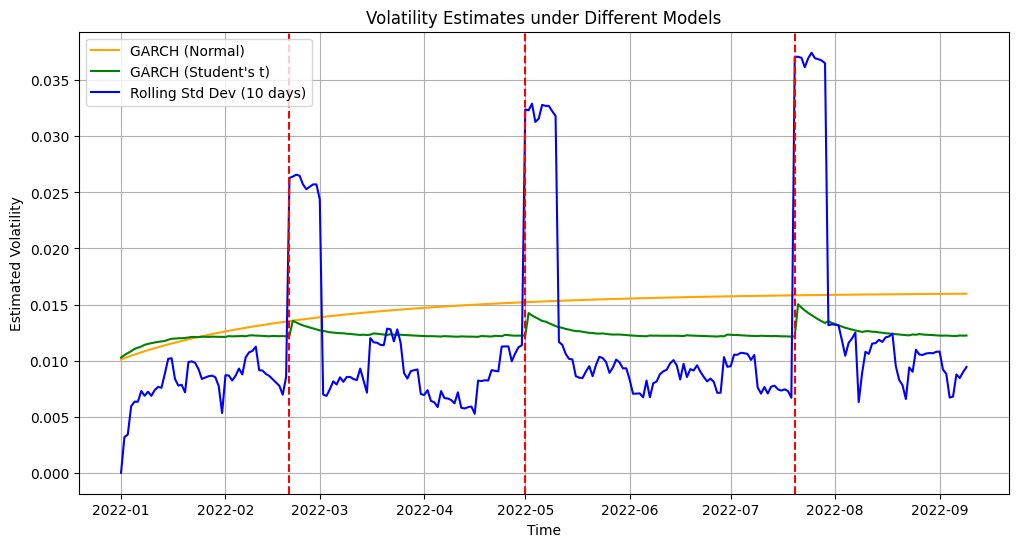

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, res_normal.conditional_volatility / 100, label='GARCH (Normal)', color='orange')
plt.plot(data.index, res_t.conditional_volatility / 100, label="GARCH (Student's t)", color='green')
plt.plot(data.index, rolling_std, label='Rolling Std Dev (10 days)', color='blue')

for outlier in data.index[data['Outlier']]:
  plt.axvline(outlier, color='red', linestyle='--')
plt.title('Volatility Estimates under Different Models')
plt.xlabel('Time')
plt.ylabel('Estimated Volatility')
plt.legend()
plt.grid(True)
plt.show()


The rolling standard deviation shows sharp, box-shaped spikes that last exactly the length of the window, indicating high sensitivity to individual extreme returns. GARCH with normal distribution produces a smooth, gradually increasing volatility curve, showing little reaction to outliers and potentially underestimating short-term risk. Since the model usually reacts very poorly to outliers, the model put a very low coefficient before the return and hardly takes this value into account, which leads to incorrect predictions that are not based on the real market. In contrast, GARCH with Student’s t-distribution displays moderate, temporary spikes in volatility following each outlier, which decay smoothly over time. This behavior suggests that the Student’s t-based GARCH model offers a balanced response—it is sensitive enough to acknowledge large shocks but robust enough to prevent a single data point from distorting the entire volatility forecast.

### **Diagram**

### **Diagnosis**

There are statistical approaches to assess sensitivity to outliers. These methods are widely used in regression and time series diagnostics [Hawkins, 1980].



##### **Visual inspection**.
The easiest way and the first one to try is to visualize the data for outliers. It is worth plotting both returns and volatility. If a single extreme return  causes a sharp and persistent spike in volatility, followed by a slow decay—even though returns normalize afterward—this is classic outlier sensitivity.


##### **Statistical tests**.
There are statistical approaches to assess sensitivity to outliers.

*   Cook’s distance. It is a way to measure how much influence a single data point has on a model’s estimates.

*  ARCH-LM Test (Engle’s Test). This test checks whether there’s any leftover autocorrelation in the squared residuals after fitting a model.

* Normality Tests on Residuals like Jarque-Bera Test or Shapiro-Wilk Test. If a model assumes normal errors (like basic GARCH does), but the residuals have fat tails or skewness, that’s a sign that outliers are distorting the model fit.

##### **Other methods**.

* Another way to assess the impact of outliers is to check how the model changes with and without them. This form of robustness check is commonly used in outlier detection frameworks [Rousseeuw & Leroy, 2005; Hodge & Austin, 2004]. Huge shifts in volatility forecasts after excluding a single data point show that the model is fragile to outliers.

* Compare with more robust methods. Less efficient but more robust methods can be used as a baseline for evaluation. If the model readings differ greatly at some points, this may be due to outliers




### **Damage**

Volatility models that are highly sensitive to outliers can produce distorted outputs, leading to serious consequences in trading, pricing, and risk management.

* **Derivative Mispricing:** Overreacting to an outlier may inflate volatility estimates, resulting in overpriced options and unnecessary hedging costs.

* **Overstated Risk Metrics:** A single extreme return can cause exaggerated risk forecasts, inefficient capital allocation, and unwarranted de-risking.

* **Hedging Inefficiencies:** Inaccurate forecasts lead to over- or under-hedging, increasing P&L volatility and weakening risk control.

* **Model Instability:** Models trained on outlier-contaminated data may learn incorrect patterns, causing forecast drift and unreliable decisions.

A notable example occurred during the COVID-19 [Aggarwal, 2017] crash in March 2020, when volatility models reacted to extreme returns with elevated risk estimates. This led to miscalibrated hedging, high transaction costs, and increased exposure, ultimately reducing trading effectiveness.


### **Directions**

To reduce sensitivity to outliers in volatility modeling, several approaches can be adopted. Robust statistics, including preprocessing and distributional assumptions, have been shown to significantly improve model stability [Iglewicz & Hoaglin, 1993; Rousseeuw & Leroy, 2005]. Below are some effective methods:

1. **Data preprocessing**. Applying winsorization, trimming, or outlier detection algorithms (e.g., Grubbs’ test or Z-score filtering) to clean the return series before model fitting can prevent outliers from biasing the estimation.

2. **Use Realized Volatility**. When high-frequency data is available, realized volatility computed from intraday returns can provide a more accurate and stable estimate that is less influenced by a single outlier at the daily level.

3. **Use Heavy-Tailed Distributions**. Replace the normal distribution with alternatives like the Student’s t or generalized error distribution to better handle extreme returns.

4. **Consider Asymmetric or Non-Linear Models**. Models like EGARCH or GJR-GARCH, and machine learning methods (e.g., random forests, RNNs) can be more resilient to outliers.

5. **Apply Robust Estimation Methods**. Robust estimation methods, such as those based on Huber loss, Tukey’s biweight function, or quantile-based estimation, reduce the impact of extreme values during model fitting by downweighting observations that deviate significantly from the median.



In summary, improving resilience to outliers requires careful model selection, thoughtful data preprocessing, and the use of estimation techniques that limit the impact of extreme values. Adopting these practices leads to more stable and reliable volatility forecasts.

### **References**
1. Bollerslev, T. (1986). Generalized Autoregressive Conditional Heteroskedasticity. Journal of Econometrics, 31(3), 307–327. https://doi.org/10.1016/0304-4076(86)90063-1
2. Tsay, R. S. (2010). Analysis of Financial Time Series (3rd ed.). Wiley.
3. Cont, R. (2001). Empirical properties of asset returns: stylized facts and statistical issues. Quantitative Finance, 1(2), 223–236. https://doi.org/10.1080/713665670
4. Rousseeuw, P. J., & Leroy, A. M. (2005). Robust Regression and Outlier Detection. Wiley-Interscience.
5. Iglewicz, B., & Hoaglin, D. C. (1993). How to Detect and Handle Outliers. ASQC Quality Press.
6. Hodge, V. J., & Austin, J. (2004). A Survey of Outlier Detection Methodologies. Artificial Intelligence Review, 22(2), 85–126. https://doi.org/10.1023/B:AIRE.0000045502.10941.a9
7. Hawkins, D. M. (1980). Identification of Outliers. Springer.
8. Aggarwal, C. C. (2017). Outlier Analysis (2nd ed.). Springer.